In [956]:
# Imports
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf

In [957]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
fruit_dict = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        fruit_dict[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [958]:
trimed_audio = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(root_dir):
    trimpath = os.path.basename(dirname)

    if trimpath in 'trimed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            trimed_audio[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [959]:
adjusted_audio = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(root_dir):
    adjustedpath = os.path.basename(dirname)

    if adjustedpath in 'adjusted':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            adjusted_audio[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [960]:
# Audio parameters
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = 256

In [961]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = len(test_audio)/sr
    return test_audio, sr, duration

In [962]:
# Function to plot the signal
def plot_signal(signal, sample_rate):
    # Duration and time vector
    duration = len(signal)/sample_rate
    
    # Time_vector
    time_vector = np.linspace(0, duration, len(signal))
    
    # Figure
    plt.figure(figsize=(15, 5))
    
    #plot
    librosa.display.waveshow(signal, sr=sample_rate, axis='time')
    
    #plt.plot(time_vector, signal, linestyle='-')
    
    # extra
    plt.title(f'Señal de Audio - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

In [963]:
# Función de ploteo del espectrograma
def plot_spectrogram(stft_power, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(stft_power, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")
    plt.show()

In [964]:
# Low pass filter
def low_pass_filter(signal, cutoff_frequency, sample_rate):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [965]:
def get_rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [966]:
def trim(signal, perc):             # The audio signal and the percentaje umbral
    signal_rms = get_rms(signal)    # RMS values for each fram
    max_rms = signal_rms.max()      # Max RMS

    umbral = perc*max_rms/100       # Umbral

    mask_rms = signal_rms > umbral

    rms_bottom_index = np.argmax(mask_rms)
    rms_upper_index = mask_rms.shape[1] - np.argmax(np.flip(mask_rms))

    bottom_index = HOP_SIZE*rms_bottom_index
    upper_index  = HOP_SIZE*(rms_upper_index + 1)

    return signal[bottom_index:upper_index]   # Trimmed signal

In [967]:
def trim_audio(perc, fruit_dict):
    trimed_dict = dict()
    for name, group in fruit_dict.items():
        trimed_fruits = []
        for fruit in group:
            signal, sr, _ = load_audio(fruit)
            trimed_signal = trim(signal, perc)
            
            output_file = os.path.join(os.path.dirname(fruit), "trimed/" + os.path.basename(fruit))
            trimed_fruits.append(output_file)
            sf.write(output_file, trimed_signal, sr)
        trimed_dict[name] = trimed_fruits
    return trimed_dict

In [968]:
def adjust_audio(fruit_dict):
    adjusted_dict = dict()
    for name, group in fruit_dict.items():
        adjusted = []
        min_duration = min(librosa.get_duration(filename=fruit) for fruit in group)

        for fruit in group:
            signal, sr, duration = load_audio(fruit)
            time_stretch_factor = duration/min_duration

            # Aplicar el estiramiento del tiempo
            adjusted_audio = librosa.effects.time_stretch(signal, rate = time_stretch_factor)
            parent = os.path.dirname(os.path.dirname(fruit))
            output_file = os.path.join(parent, "adjusted/" + os.path.basename(fruit))

            adjusted.append(output_file)
            sf.write(output_file, adjusted_audio, sr)
        adjusted_dict[name] = adjusted
    return adjusted_dict
        


In [969]:
def get_features(n_mfcc, fruit_dict):
    fruit_vectors = dict.fromkeys(fruit_types)
    for fruit_name, fruits in fruit_dict.items():
        vectors = list()
        for fruit in fruits:
            signal, sr, _ = load_audio(fruit)
            #signal = trim(signal, 15)

            #signal_stft  = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE) # STFT
            #signal_power = np.abs(signal_stft) ** 2                                        # Power Spectrum
            #signal_power_db = librosa.power_to_db(signal_power)                            # Simply gets the db values
            #signal_mel_spectrogram = librosa.feature.melspectrogram(y = signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=20) # Mel spectrogram
            #signal_mel_spectrogram_db = librosa.power_to_db(signal_mel_spectrogram)

            mfccs = librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc, sr=sr)                      # Gets the Mel coeeficients
            fruit_vector = np.mean(mfccs, axis=1)
            vectors.append(fruit_vector.T)
        fruit_vectors[fruit_name] = np.array(vectors)
         

    return fruit_vectors

In [970]:
def get_sphere(vectors):
    center = np.mean(vectors, axis = 0)
    center = center.reshape((1, len(center)))
    radius = cdist(center, vectors).max()     # Pairwise distance
    return radius, center

In [971]:
def get_overlaps(fruit_features):
    radiuses = dict.fromkeys(fruit_types) # A dictionary for the radius
    centers = dict.fromkeys(fruit_types)  # A dictionary for the centers

    for name, group in fruit_features.items():
        radius, center = get_sphere(group) # The sphere that evolves the group
        radiuses[name] = radius
        centers[name] = center

    overlaps = dict.fromkeys(fruit_types)
    # A dictionary of dictionarys. Keys, the fruit types
    for key in overlaps:
        # Each dictionary in the dictionary
        overlaps[key] = dict.fromkeys(fruit_types)
    
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            distancesAB = cdist(centers[fruit_types[i]], fruit_features[fruit_types[j]])
            distancesBA = cdist(centers[fruit_types[j]], fruit_features[fruit_types[i]])

            mask_distancesAB = distancesAB < radiuses[fruit_types[i]]
            mask_distancesBA = distancesBA < radiuses[fruit_types[j]]

            numberBinA = np.count_nonzero(mask_distancesAB)
            numberAinB = np.count_nonzero(mask_distancesBA)

            overlaps[fruit_types[i]][fruit_types[j]] = numberBinA
            overlaps[fruit_types[j]][fruit_types[i]] = numberAinB
    return overlaps # Each element is the number of vectors of one group in the sphere of anhoter

In [972]:
def get_table(centers):
    from prettytable import PrettyTable
    table = PrettyTable()
    table.field_names = ["par"] + [f"{i}" for i in range(1, centers[fruit_types[0]].shape[1] + 1)]

    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):

            key = f"{fruit_types[i]}-{fruit_types[j]}"
            centerdif = centers[fruit_types[i]] - centers[fruit_types[j]]
            difperc = centerdif*100/cdist(centers[fruit_types[i]], centers[fruit_types[j]])

            table.add_row([key] + centerdif[0].tolist())
            table.add_row([f"{key}-%"] + difperc[0].tolist())
    table.float_format = "0.2"
    return table

In [973]:
def get_centers(features):
    centers = dict.fromkeys(fruit_types)
    for fruit, group in features.items():
        _, center = get_sphere(group)
        centers[fruit] = center
    return centers

In [974]:
def get_components(centers, nc):
    pacum = np.zeros((1, centers[fruit_types[0]].shape[1]))
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            dif = centers[fruit_types[i]] - centers[fruit_types[j]]
            dist = cdist(centers[fruit_types[i]], centers[fruit_types[j]])
            difp = (dif**2)*100/(dist**2)
            pacum += difp
    index_max = np.argsort(pacum[0])[-nc:]
    #return np.sort(index_max)
    return index_max


In [975]:
def get_varianzs(features, nc):
    varianzs = dict.fromkeys(fruit_types)
    for fruit, group in features.items():
        var = np.var(group, axis = 0)
        varianzs[fruit] = np.argsort(var)[:nc]
    return varianzs

In [976]:
#trimed_audio   = trim_audio(25, fruit_dict)
#adjusted_audio = adjust_audio(trimed_audio)

In [ ]:
fruit_features = get_features(5, trimed_audio) # Extract the 

index = get_components(get_centers(fruit_features), 5)
print(index)
index = [3, 4]
print(index)
print(get_varianzs(fruit_features, 5))

for group in fruit_features:
    fruit_features[group] = fruit_features[group][:, index]

centers = get_centers(fruit_features)
center_list = list(centers.values())
center_matrix = np.squeeze(center_list, axis=1)

radius, _ = get_sphere(center_matrix)
print(radius)

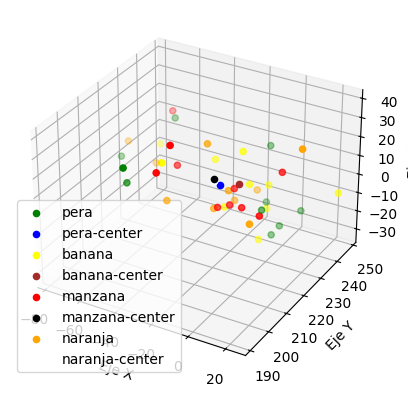

In [978]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Configure colors
colors = dict(zip(fruit_types,['green','yellow','red','orange']))
centers = get_centers(fruit_features)
center_colors  = dict(zip(fruit_types,['blue','brown','black','white']))
"""
# Plotear los puntos para cada grupo
for fruit, points in fruit_features.items():
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
    ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

# configure labels
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

"""

for fruit, points in fruit_features.items():
    plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)
    plt.scatter(centers[fruit][:, 0], centers[fruit][:, 1], c = center_colors[fruit], label = f"{fruit}-center")

# Configurar etiquetas de ejes
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Mostrar leyenda
# plt.legend()

# Mostrar el gráfico
plt.show()